In [1]:
%load_ext autoreload
%autoreload 2
    
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
from models.diffusion import StableDiffusion
import torch
from torchvision import transforms
from transformers import CLIPTokenizer
from PIL import Image
from utils.model_converter import load_weights_from_ckpt
from torch.ao.quantization import QConfig, HistogramObserver, MinMaxObserver


prompt = "A cat is sitting, looking out the window"
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

# Comment to disable image to image
input_image = None
image_path = "./images/dog.jpg"
input_image = Image.open(image_path).convert('RGB')

# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.1

## SAMPLER
num_inference_steps = 50
seed = 42
model = StableDiffusion(model_type='txt2img')
loaded_state_dict = load_weights_from_ckpt('./weights/model/v1-5-pruned-emaonly.ckpt', device='cpu')
model.vae.load_state_dict(loaded_state_dict['vae'], strict=True)
model.unet.load_state_dict(loaded_state_dict['unet'], strict=True)
model.cond_encoder.load_state_dict(loaded_state_dict['cond_encoder'], strict=True)

tokenizer = CLIPTokenizer('./weights/tokenizer/tokenizer_vocab.json', merges_file='./weights/tokenizer/tokenizer_merges.txt')

/Users/dnnhhuy/Study/pytorch-course/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from utils import quantize_model
quantized_cond_encoder = quantize_model.quantize_cond_encoder(model.cond_encoder, tokenizer=tokenizer)
quantized_vae = quantize_model.quantize_vae(model.vae)
quantized_unet = quantize_model.quantize_unet(model.unet)

In [3]:
model.unet = quantized_unet
model.vae = quantized_vae
model.cond_encoder = quantized_cond_encoder

In [8]:
%load_ext autoreload
%autoreload 2
output_image = model.generate(
    input_image=None,
    img_size=(512, 512),
     prompt="A cozy mountain cabin at sunrise",
     uncond_promt=uncond_prompt,
     do_cfg=do_cfg,
     cfg_scale=cfg_scale,
     device='cpu',
     strength=0.2,
     inference_steps=num_inference_steps,
     sampler='ddpm',
     use_cosine_schedule=False,
     seed=seed,
     tokenizer=tokenizer
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|████████████████████████████| 50/50 [05:12<00:00,  6.25s/it]


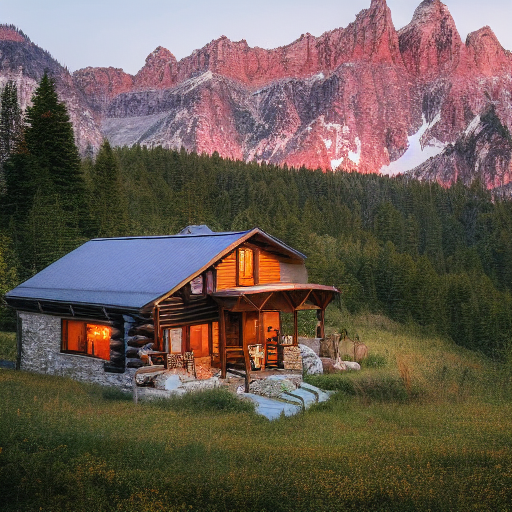

In [9]:
Image.fromarray(output_image)

In [6]:
torch.save(model.state_dict(), './quantized_model.pth')
os.path.getsize('./quantized_model.pth') / (1024 * 1024)

3046.742706298828

In [1]:
%load_ext autoreload
%autoreload 2
!python3 train.py --device=mps --batch_size 8 --data_dir ./data/sprites/

  0%|                                                  | 0/8940 [00:00<?, ?it/s]^C
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x10e6638b0>
Traceback (most recent call last):
  File "/Users/dnnhhuy/Study/pytorch-course/env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Users/dnnhhuy/Study/pytorch-course/env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/dnnhhuy/Study/pytorch-course/env/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/dnnhhuy/Study/pytorch-course/env/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/Users/dnnhhuy/Study/pytorch-course/env/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(tim